In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Constants:
    G = 6.674e-11
    massEarth = 5.972e24
    
class Size:
    m = 1
    km = 1000 * m

class Time:
    second = 1
    minute = 60 * second
    hour = 60 * minute
    day = 24 * hour


In [3]:
class SpaceObject:
    def __init__(self, name: str, mass: float, position: np.array, velocity: np.array):
        self.name = name
        self.mass = mass
        assert position.size == 3 and velocity.size == 3, "Vectors should have 3 dimensions!"
        self.position = position
        self.velocity = velocity
    
    def __str__(self):
        return f'"{self.name}" mass={self.mass}'
    

In [4]:
class Logger:
    ERROR_CODE = 0
    INFO_CODE = 1
    MEASURE_CODE = 2

    def log(self, code, msg): 
        pass
    def _prefix(self, code):
        m = {
            Logger.ERROR_CODE: "[ERROR]: ",
            Logger.INFO_CODE: "[INFO]: ",
            Logger.MEASURE_CODE: "[MEASUREMENT]: ",
        }
        codeIsCorrect = False
        for allowCode in m:
            if code == allowCode:
                codeIsCorrect = True
        assert codeIsCorrect, "Passed log code is incorrect!"
        return m[code]

class FileLogger(Logger):
    def __init__(self, filename):
        self.__f = open(filename, 'w')

    def log(self, code, msg):
        msg = self._prefix(code) + msg + '\n'
        self.__f.write(msg)
            
    def __del__(self):
        self.__f.close()
        print("Logger deleted")

class PrintLogger(Logger):
    def log(self, code, msg):
        msg = self._prefix(code) + msg
        print(msg)
        

In [5]:
def createVector(x = 0, y = 0, z = 0) -> np.array:
    return np.array([x, y, z], float)

def cross(a: np.array, b: np.array) -> np.array:
    assert a.size == b.size, "Vectors must have same sizes!"
    assert a.size == 3, "Only 3-dimensional vectors allowed!"
    x,y,z = a
    a,b,c = b
    return createVector( y*c - b*z, a*z - c*x, x*b - a*y )

def dot(a: np.array, b: np.array) -> float:
    assert a.size == b.size, "Vectors must have same sizes!"
    return sum([a[i] * b[i] for i in range(a.size)])

In [6]:
class Simulation():
    def __init__(self, objects: list[SpaceObject], DE, logger: Logger = None, logCnt = 20):  
        self.objects = objects
        self.state = np.concatenate(
            [np.concatenate((obj.position, obj.velocity)) for obj in self.objects]
            )
        self.masses = np.array([obj.mass for obj in self.objects])
        self.objQuantity = self.masses.size
        self.DE = DE
        self.logger = logger
        self.logCnt = logCnt
    
    def method_RK4(self, dt: float) -> np.array:
        k1 = self.DE(self.state, self.masses, dt) 
        k2 = self.DE(self.state + 0.5 * k1, self.masses, dt)
        k3 = self.DE(self.state + 0.5 * k2, self.masses, dt)
        k4 = self.DE(self.state + k3, self.masses, dt)

        return self.state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    def run(self, T, dt):
        assert dt > 0, "dt must be positive value!"
        assert T > 0, "T must be positive value!"
        assert T / dt >= 1, "Step size must be less than total time!"

        self.history = [self.state]
        
        steps = int(T / dt)
        start_time = time.time()

        infoStep = int(steps / self.logCnt)
        
        for step in range(steps):
            self.state = self.method_RK4(dt)
            self.history.append(self.state)
            
            #sys.stdout.flush()
            if step % infoStep == 0:
                self.logState(f"Simulation step {step + 1} / {steps}")

        self.history = np.array(self.history)

        finishMsg = f"Simulation completed in {round(time.time() - start_time, 3)} seconds. Total steps: {steps}"
        self.logState("Final configuration:")
        if self.logger != None:
            self.logger.log(Logger.INFO_CODE, finishMsg)
    
    def logState(self, msg):
        if self.logger != None:
            self.logger.log(Logger.INFO_CODE, msg)
            impulse = self.evaluateImpulse()
            impMoment = self.evaluateImpulseMoment()
            energy = self.evaluateEnergy()
            self.logger.log(Logger.MEASURE_CODE, f"Impulse: {impulse}")
            self.logger.log(Logger.MEASURE_CODE, f"Impulse moment: {impMoment}")
            self.logger.log(Logger.MEASURE_CODE, f"Energy: {energy}")

    def evaluateImpulse(self):
        p = createVector()
        for i in range(self.objQuantity):
            p_i = self.masses[i] * np.array(self.state[i*6 + 3 : i*6 + 6])
            p += p_i
        return p

    def evaluateImpulseMoment(self):
        M = createVector()
        for i in range(self.objQuantity):
            p_i = self.masses[i] * np.array(self.state[i * 6 + 3 : i * 6 + 6])
            r_i = np.array(self.state[i * 6 : i * 6 + 3])
            M += cross(p_i, r_i)
        return M

    def evaluateEnergy(self):
        E_all = 0

        for i in range(self.objQuantity):
            v = np.array(self.state[i*6 + 3 : i*6 + 6])
            E_kin = self.masses[i] * dot(v, v) / 2
            r1 = np.array(self.state[i*6 : i*6 + 3])
            Gm = -Constants.G*self.masses[i]
            E_pot = 0

            for j in range(self.objQuantity):
                if i == j: continue
                r2 = np.array(self.state[j * 6 : j * 6 + 3])
                R = dot(r1 - r2, r1 - r2) ** (1/2)
                E_pot += Gm*self.masses[j] / R

            E_all += E_pot / 2 + E_kin

        return E_all

    

In [7]:
def systemDE(state, masses, dt):
    objQuantity = int(len(state) / 6)
    answer = np.zeros(state.size)
    
    for i in range(objQuantity):
        answer[i * 6: i * 6 + 3] = dt * state[i * 6 + 3 : i * 6 + 6] # dr = v * dt
        
        for j in range(objQuantity): 
            if i == j: continue
            rx = state[i * 6 + 0] - state[j * 6 + 0] 
            ry = state[i * 6 + 1] - state[j * 6 + 1]
            rz = state[i * 6 + 2] - state[j * 6 + 2] 
            r = (rx ** 2 + ry ** 2 + rz ** 2) ** 0.5 # r
            
            GM_r = -Constants.G * masses[j] / r**3
            ax = GM_r * rx 
            ay = GM_r * ry 
            az = GM_r * rz 
            answer[i * 6 + 3] += ax * dt # dvx = sum [aj]x * dt
            answer[i * 6 + 4] += ay * dt # dvy = sum [aj]y * dt
            answer[i * 6 + 5] += az * dt # dvz = sum [aj]z * dt
                
    return answer 

In [8]:
def paint(simulation: Simulation):
    plot = plt.figure(figsize=[15, 12]).add_subplot(111, projection='3d')

    markerSizes = ([20] + [0.5]*(simulation.history.size // simulation.objQuantity // 6 - 2) + [40])

    for index in range(len(simulation.objects)):
        plot.scatter(
            [state[0 + 6 * index] for state in simulation.history],  # X's
            [state[1 + 6 * index] for state in simulation.history],  # Y's
            [state[2 + 6 * index] for state in simulation.history],  # Z's
                s = markerSizes, label = simulation.objects[index].name
                )
        sys.stdout.write(f"Painting body #{index} \"{simulation.objects[index].name}\"\n")

    plot.legend()

[INFO]: Simulation step 1 / 14400
[MEASUREMENT]: Impulse: [ 7.5047496e+25  3.0759800e+23 -1.0900000e+23]
[MEASUREMENT]: Impulse moment: [1.98598000e+28 2.00560000e+31 2.88194157e+34]
[MEASUREMENT]: Energy: -1.1480732078307526e+29
[INFO]: Simulation step 361 / 14400
[MEASUREMENT]: Impulse: [ 7.5047496e+25  3.0759800e+23 -1.0900000e+23]
[MEASUREMENT]: Impulse moment: [1.98598000e+28 2.00560000e+31 2.88194157e+34]
[MEASUREMENT]: Energy: -1.1478353592189617e+29
[INFO]: Simulation step 721 / 14400
[MEASUREMENT]: Impulse: [ 7.5047496e+25  3.0759800e+23 -1.0900000e+23]
[MEASUREMENT]: Impulse moment: [1.98598000e+28 2.00560000e+31 2.88194157e+34]
[MEASUREMENT]: Energy: -1.1476159919353654e+29
[INFO]: Simulation step 1081 / 14400
[MEASUREMENT]: Impulse: [ 7.5047496e+25  3.0759800e+23 -1.0900000e+23]
[MEASUREMENT]: Impulse moment: [1.98598000e+28 2.00560000e+31 2.88194157e+34]
[MEASUREMENT]: Energy: -1.1474730879700028e+29
[INFO]: Simulation step 1441 / 14400
[MEASUREMENT]: Impulse: [ 7.5047496e

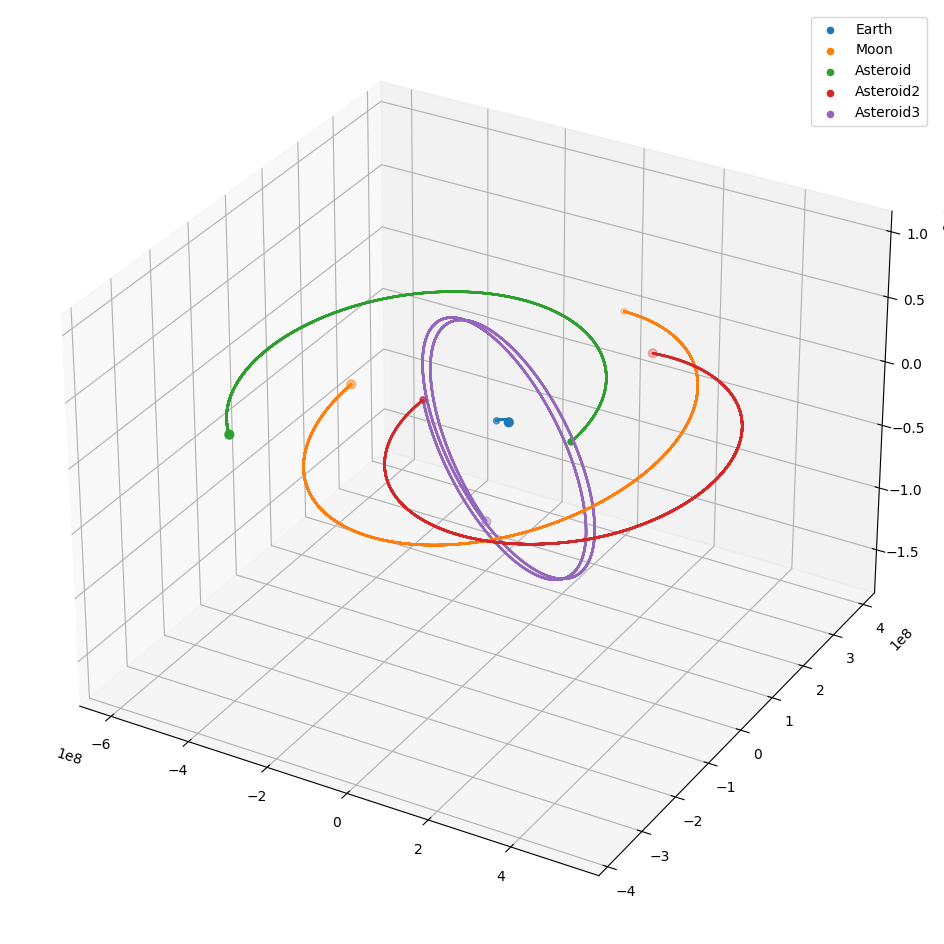

In [43]:
def test5():
    
    Moon = SpaceObject("Moon",
                mass = 7.3477e22,
                position = createVector(0, 3.84e5, 0) * Size.km,
                velocity = createVector(1.022, 0, 0) * Size.km / Time.second)

    Earth = SpaceObject("Earth",
                mass = Constants.massEarth,
                position = createVector(0, 0, 0) * Size.km,
                velocity = createVector(0, 0, 0) * Size.km / Time.second)

    Asteroid1 = SpaceObject("Asteroid",
                mass = 1.09e20,
                position = createVector(1.84e5, 0, 1e2) * Size.km,
                velocity = createVector(0, 1822, 0) * Size.m / Time.second)

    Asteroid2 = SpaceObject("Asteroid2",
                mass = 1.09e10,
                position = createVector(-1.84e5, 0, -1e2) * Size.km,
                velocity = createVector(1, -1822, 0) * Size.m / Time.second)

    Asteroid3 = SpaceObject("Asteroid3",
                mass = 1.09e20,
                position = createVector(-1.84e5, 0, 0) * Size.km,
                velocity = createVector(-0.422, 1, -1) * Size.km / Time.second)
    logger = PrintLogger()
    simulation = Simulation(
        [Earth, Moon, Asteroid1, Asteroid2, Asteroid3], systemDE, logger, 40
        )
    simulation.run(20 * Time.day, 2 * Time.minute)

    paint(simulation)

test5()

[INFO]: Simulation step 1 / 4320
[MEASUREMENT]: Impulse: [ 3.55349400e+24 -1.98598021e+13  3.72529030e-09]
[MEASUREMENT]: Impulse moment: [1.98598000e+18 1.09000000e+15 5.02979017e+34]
[MEASUREMENT]: Energy: -2.6460426426868234e+29
[INFO]: Simulation step 109 / 4320
[MEASUREMENT]: Impulse: [ 3.55349400e+24 -1.98571971e+13  9.53674316e-07]
[MEASUREMENT]: Impulse moment: [1.98598000e+18 1.09000000e+15 5.02979017e+34]
[MEASUREMENT]: Energy: -2.6476392015723814e+29
[INFO]: Simulation step 217 / 4320
[MEASUREMENT]: Impulse: [ 3.55349400e+24 -1.98525242e+13  1.43051147e-06]
[MEASUREMENT]: Impulse moment: [1.98598000e+18 1.09000000e+15 5.02979017e+34]
[MEASUREMENT]: Energy: -2.6523955930536924e+29
[INFO]: Simulation step 325 / 4320
[MEASUREMENT]: Impulse: [ 3.55349400e+24 -1.98661494e+13  2.86102295e-06]
[MEASUREMENT]: Impulse moment: [1.98598000e+18 1.09000000e+15 5.02979017e+34]
[MEASUREMENT]: Energy: -2.660385470651261e+29
[INFO]: Simulation step 433 / 4320
[MEASUREMENT]: Impulse: [ 3.5534

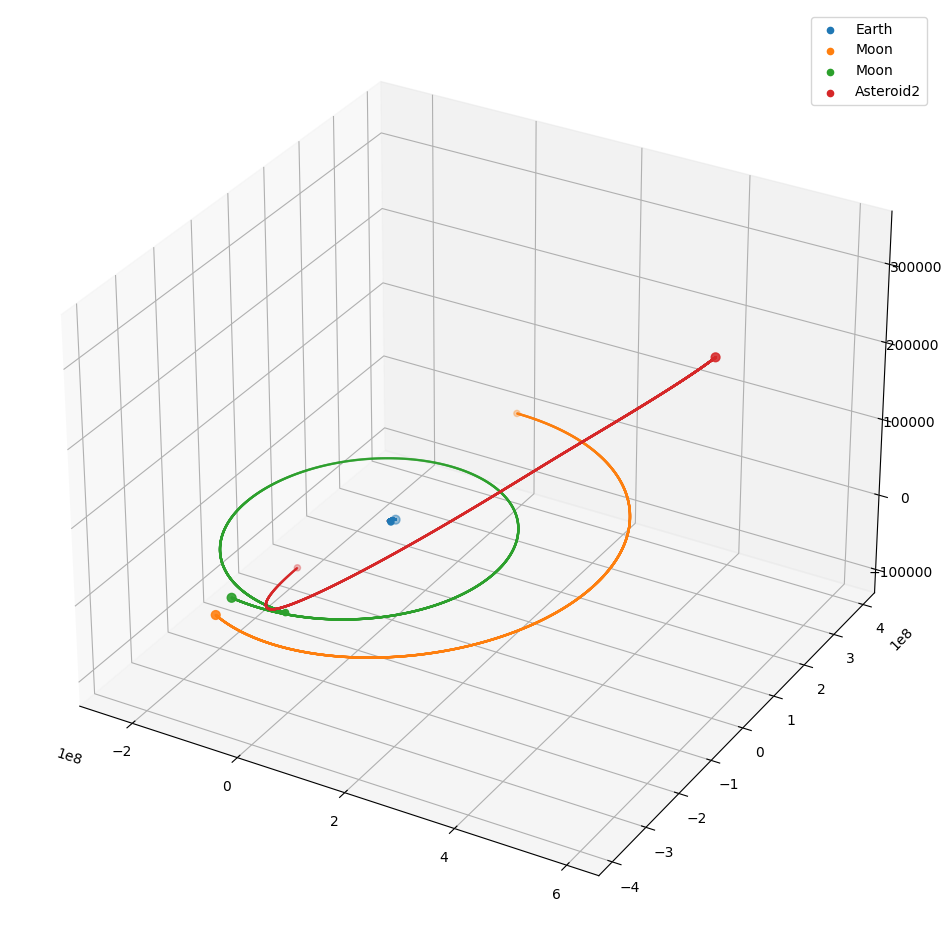

In [44]:
def test4():
    
    Moon = SpaceObject("Moon",
                mass = 7.3477e22,
                position = createVector(0, 3.84e5, 0) * Size.km,
                velocity = createVector(1.022, 0, 0) * Size.km / Time.second)

    Earth = SpaceObject("Earth",
                mass = Constants.massEarth,
                position = createVector(0, 0, 0) * Size.km,
                velocity = createVector(0, 0, 0) * Size.km / Time.second)

    Moon2 = SpaceObject("Moon",
                mass = 7e22,
                position = -createVector(0, 3e5, 0) * Size.km,
                velocity = -createVector(1.022, 0, 0) * Size.km / Time.second)

    Asteroid2 = SpaceObject("Asteroid2",
                mass = 1.09e10,
                position = createVector(-1.84e5, 0, -1e2) * Size.km,
                velocity = createVector(1, -1822, 0) * Size.m / Time.second)

    logger = PrintLogger()
    simulation = Simulation(
        [Earth, Moon, Moon2, Asteroid2], systemDE, logger, 40
        )
    simulation.run(15 * Time.day, 5 * Time.minute)
    paint(simulation)
test4()

[INFO]: Simulation step 1 / 5760
[MEASUREMENT]: Impulse: [0.00000000e+00 1.72805325e+09 0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.238572764257465e+28
[INFO]: Simulation step 1153 / 5760
[MEASUREMENT]: Impulse: [5.61030103e+10 6.87194767e+10 0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727642590655e+28
[INFO]: Simulation step 2305 / 5760
[MEASUREMENT]: Impulse: [ 5.79820585e+10 -3.22122547e+10  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727642590735e+28
[INFO]: Simulation step 3457 / 5760
[MEASUREMENT]: Impulse: [ 2.57698038e+10 -3.46952827e+10  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727642590774e+28
[INFO]: Simulation step 4609 / 5760
[MEASUREMENT]: Impulse

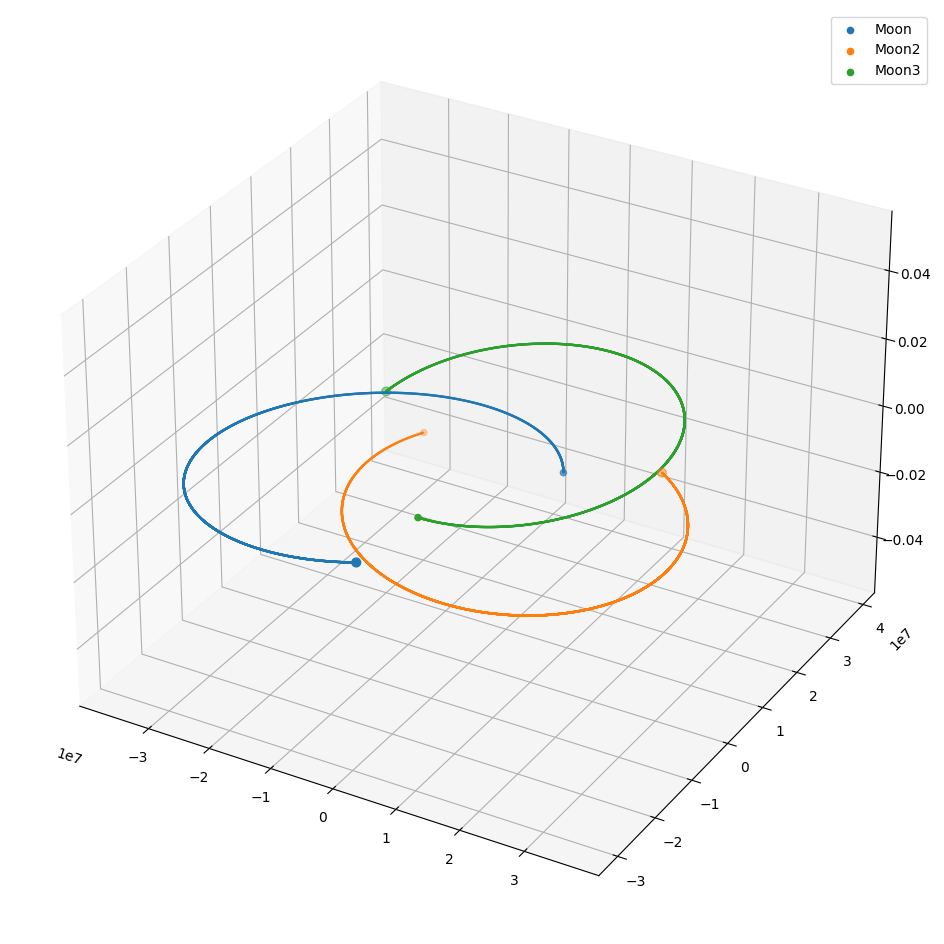

In [36]:
def test3():
    
    Moon = SpaceObject("Moon",
                mass = 1e23,
                position = createVector(1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, 1.73, 0) * Size.km / Time.second / 3)

    Moon2 = SpaceObject("Moon2",
                mass = 1e23,
                position = createVector(-1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, -1.73, 0) * Size.km / Time.second / 3)

    Moon3 = SpaceObject("Moon3",
                mass = 1e23,
                position = createVector(0, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(2, 0, 0) * Size.km / Time.second / 3)

    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2, Moon3], systemDE, logger, 5
        )
    simulation.run(4 * Time.day, 1 * Time.minute)
    paint(simulation)
test3()

[INFO]: Simulation step 1 / 1440
[MEASUREMENT]: Impulse: [1.e+22 1.e+23 0.e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59737833e+33]
[MEASUREMENT]: Energy: -2.259971698836368e+28
[INFO]: Simulation step 289 / 1440
[MEASUREMENT]: Impulse: [1.e+22 1.e+23 0.e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59737833e+33]
[MEASUREMENT]: Energy: -2.259972303319235e+28
[INFO]: Simulation step 577 / 1440
[MEASUREMENT]: Impulse: [1.e+22 1.e+23 0.e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59737833e+33]
[MEASUREMENT]: Energy: -2.2599730938236455e+28
[INFO]: Simulation step 865 / 1440
[MEASUREMENT]: Impulse: [1.e+22 1.e+23 0.e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59737833e+33]
[MEASUREMENT]: Energy: -2.259973803638969e+28
[INFO]: Simulation step 1153 / 1440
[MEASUREMENT]: Impulse: [1.e+22 1.e+23 0.e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59737833e+33]
[

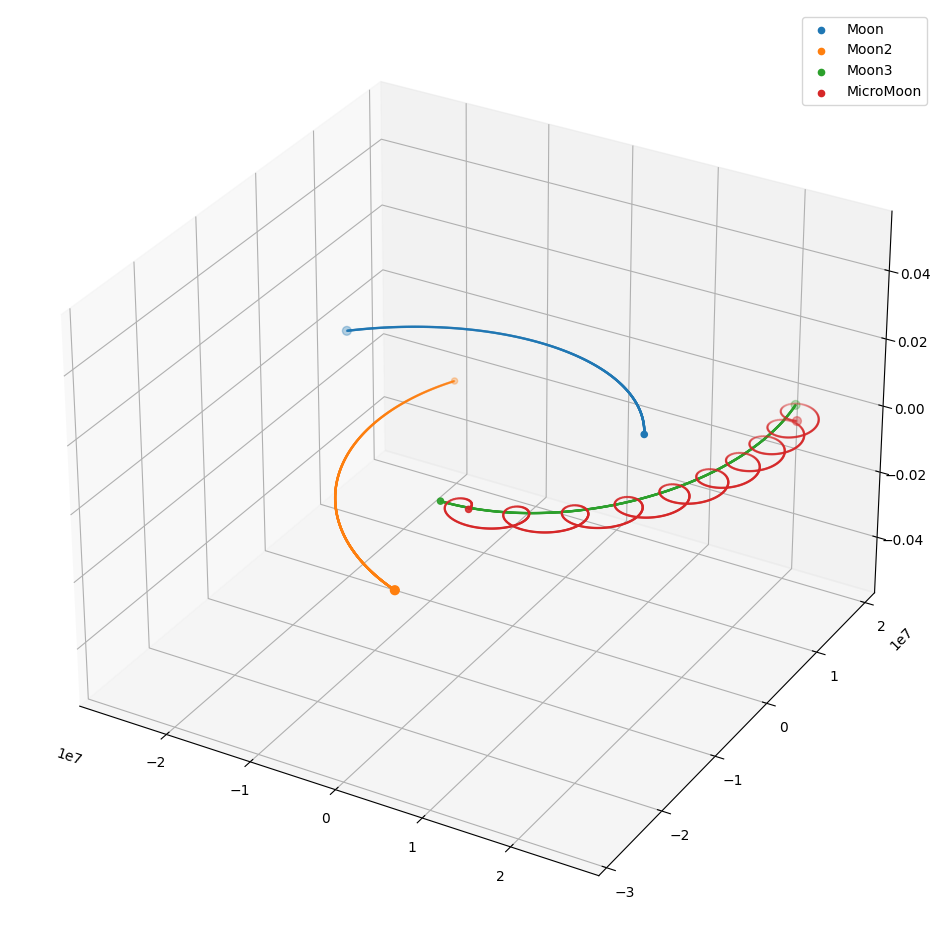

In [55]:
def test3_flies_around():
    
    Moon = SpaceObject("Moon",
                mass = 1e23,
                position = createVector(1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, 1.73, 0) * Size.km / Time.second / 3)

    Moon2 = SpaceObject("Moon2",
                mass = 1e23,
                position = createVector(-1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, -1.73, 0) * Size.km / Time.second / 3)

    Moon3 = SpaceObject("Moon3",
                mass = 1e23,
                position = createVector(0, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(2, 0, 0) * Size.km / Time.second / 3)
    MicroMoon = \
            SpaceObject("MicroMoon",
                mass = 1e20,
                position = createVector(0.5, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(0.1, 1, 0) * Size.km / Time.second)
    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2, Moon3, MicroMoon], systemDE, logger, 5
        )
    simulation.run(1 * Time.day, 1 * Time.minute)
    paint(simulation)
test3_flies_around()

[INFO]: Simulation step 1 / 12960
[MEASUREMENT]: Impulse: [2.50392937e+12 1.59983742e+13 0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727642587986e+28
[INFO]: Simulation step 2593 / 12960
[MEASUREMENT]: Impulse: [2.45831545e+12 1.61236598e+13 0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727642604157e+28
[INFO]: Simulation step 5185 / 12960
[MEASUREMENT]: Impulse: [2.45245999e+12 1.62059275e+13 0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.238572764260421e+28
[INFO]: Simulation step 7777 / 12960
[MEASUREMENT]: Impulse: [2.27521143e+12 1.64308343e+13 0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.238572764260335e+28
[INFO]: Simulation step 10369 / 12960
[MEASUREMENT]: Impulse:

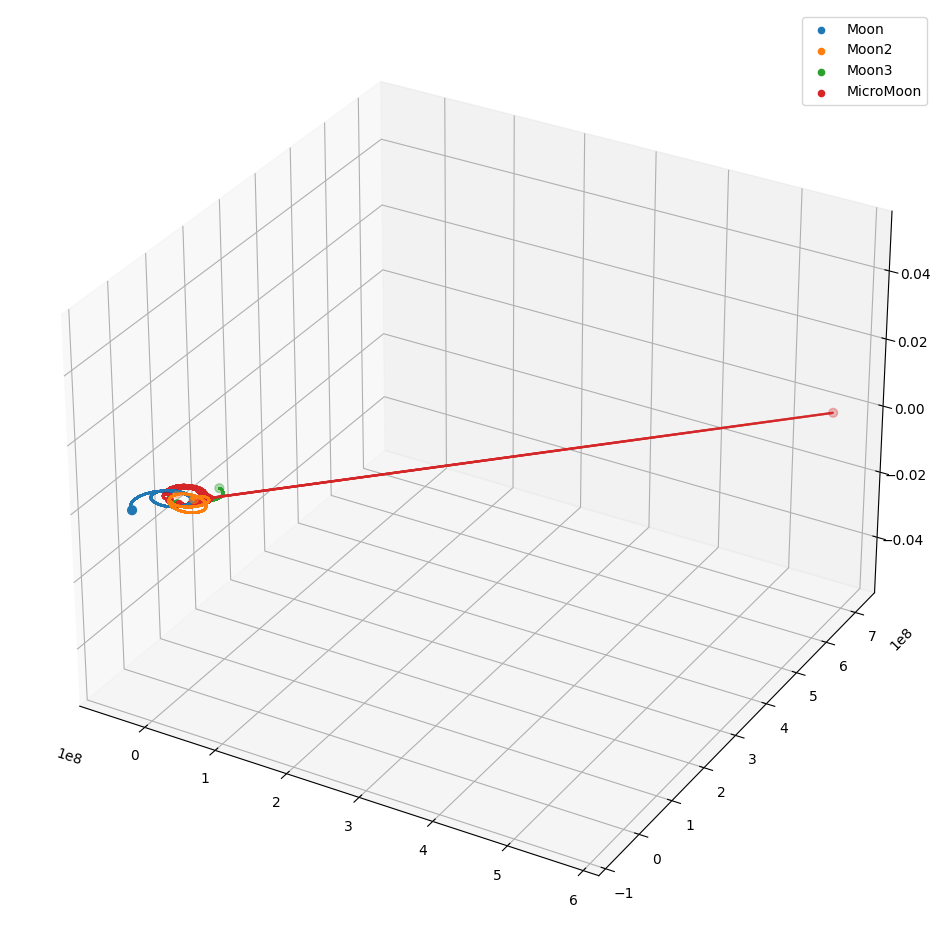

In [14]:
def test3_stays():
    
    Moon = SpaceObject("Moon",
                mass = 1e23,
                position = createVector(1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, 1.73, 0) * Size.km / Time.second / 3)

    Moon2 = SpaceObject("Moon2",
                mass = 1e23,
                position = createVector(-1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, -1.73, 0) * Size.km / Time.second / 3)

    Moon3 = SpaceObject("Moon3",
                mass = 1e23,
                position = createVector(0, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(2, 0, 0) * Size.km / Time.second / 3)
    MicroMoon = \
            SpaceObject("MicroMoon",
                mass = 1e10,
                position = createVector(0.5, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(0.25, 1.6, 0) * Size.km / Time.second)
    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2, Moon3, MicroMoon], systemDE, logger, 5
        )
    simulation.run(9 * Time.day, 1 * Time.minute)
    paint(simulation)
test3_stays()

[INFO]: Simulation step 1 / 1800
[MEASUREMENT]: Impulse: [-2.49867196e+12 -1.60117543e+13  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727642591944e+28
[INFO]: Simulation step 361 / 1800
[MEASUREMENT]: Impulse: [-2.47853315e+12 -1.60539780e+13  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.23857276468475e+28
[INFO]: Simulation step 721 / 1800
[MEASUREMENT]: Impulse: [-2.41857258e+12 -1.60492854e+13  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727646860582e+28
[INFO]: Simulation step 1081 / 1800
[MEASUREMENT]: Impulse: [-2.41082924e+12 -1.60157363e+13  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727646860354e+28
[INFO]: Simulation step 1441 / 1800
[MEASUREMENT]: Impu

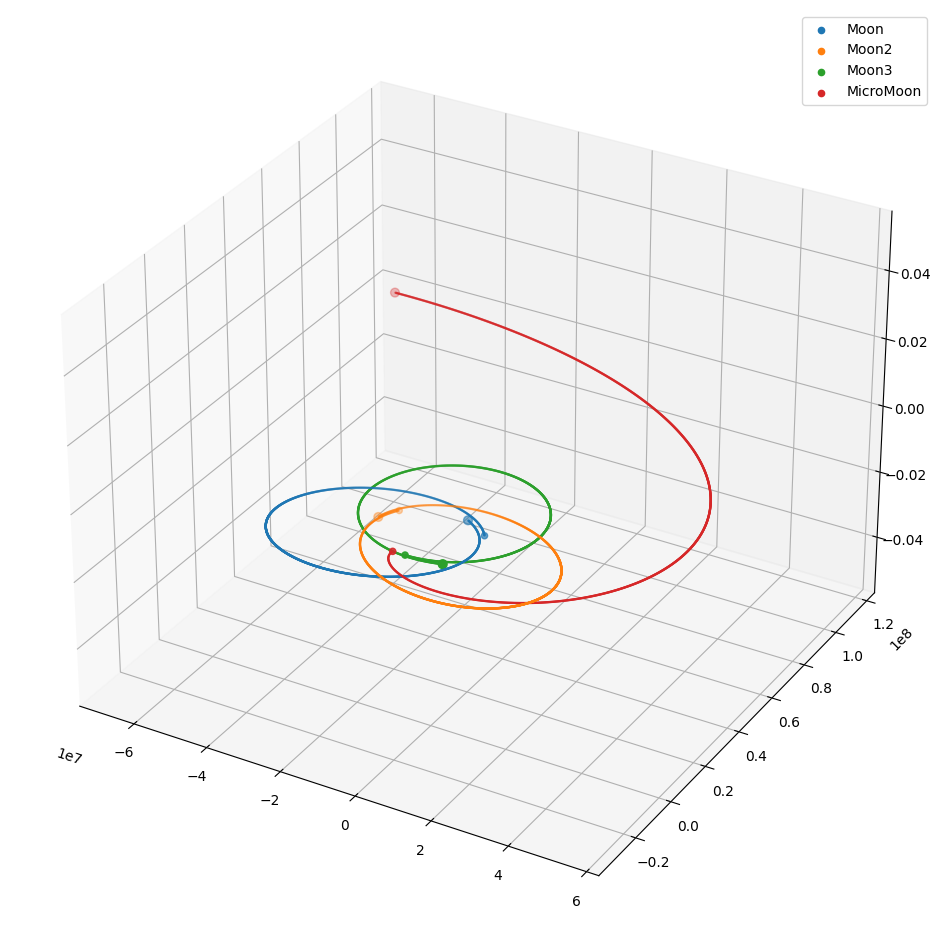

In [11]:
def test3_uletael_spiral():
    
    Moon = SpaceObject("Moon",
                mass = 1e23,
                position = createVector(1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, 1.73, 0) * Size.km / Time.second / 3)

    Moon2 = SpaceObject("Moon2",
                mass = 1e23,
                position = createVector(-1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, -1.73, 0) * Size.km / Time.second / 3)

    Moon3 = SpaceObject("Moon3",
                mass = 1e23,
                position = createVector(0, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(2, 0, 0) * Size.km / Time.second / 3)
    MicroMoon = \
            SpaceObject("MicroMoon",
                mass = 1e10,
                position = createVector(-0.5, -2, 0) * Size.km * 6.5e3,
                velocity = -createVector(0.25, 1.6, 0) * Size.km / Time.second)
    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2, Moon3, MicroMoon], systemDE, logger, 5
        )
    simulation.run(5 * Time.day, 4 * Time.minute)
    paint(simulation)
test3_uletael_spiral()

[INFO]: Simulation step 1 / 30240
[MEASUREMENT]: Impulse: [-2.19708257e+12 -1.60043408e+13  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727642587405e+28
[INFO]: Simulation step 7561 / 30240
[MEASUREMENT]: Impulse: [-2.31321735e+12 -1.62636612e+13  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727642601435e+28
[INFO]: Simulation step 15121 / 30240
[MEASUREMENT]: Impulse: [-2.21933090e+12 -1.63623478e+13  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.2385727645148155e+28
[INFO]: Simulation step 22681 / 30240
[MEASUREMENT]: Impulse: [-2.32684134e+12 -1.68842604e+13  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692333e+33]
[MEASUREMENT]: Energy: -2.238572777553036e+28
[INFO]: Final configuration:
[MEASUREMENT]: Im

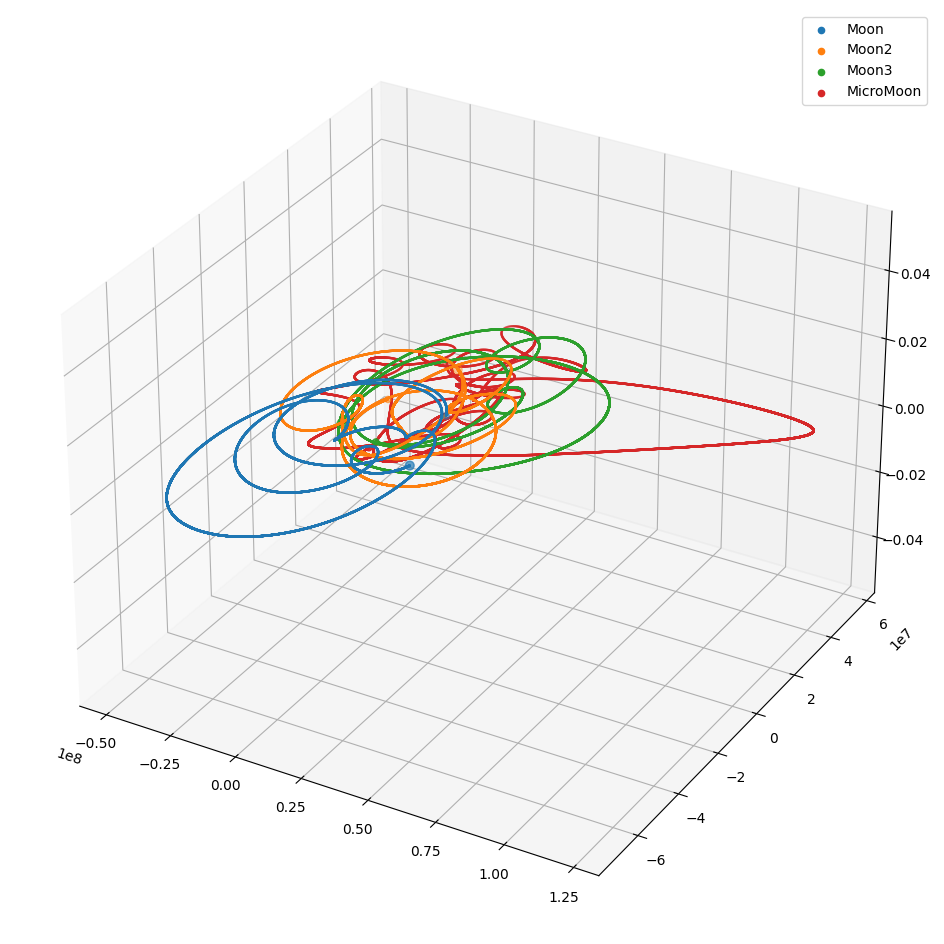

In [17]:
def test3_chaos():
    
    Moon = SpaceObject("Moon",
                mass = 1e23,
                position = createVector(1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, 1.73, 0) * Size.km / Time.second / 3)

    Moon2 = SpaceObject("Moon2",
                mass = 1e23,
                position = createVector(-1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, -1.73, 0) * Size.km / Time.second / 3)

    Moon3 = SpaceObject("Moon3",
                mass = 1e23,
                position = createVector(0, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(2, 0, 0) * Size.km / Time.second / 3)
    MicroMoon = \
            SpaceObject("MicroMoon",
                mass = 1e10,
                position = createVector(0, -2.5, 0) * Size.km * 6.5e3,
                velocity = -createVector(0.22, 1.6, 0) * Size.km / Time.second)
    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2, Moon3, MicroMoon], systemDE, logger, 4
        )
    simulation.run(21  * Time.day, 1 * Time.minute)
    paint(simulation)
test3_chaos()

[INFO]: Simulation step 1 / 72000
[MEASUREMENT]: Impulse: [1.e+21 1.e+22 0.e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59692788e+33]
[MEASUREMENT]: Energy: -2.253980621908295e+28
[INFO]: Simulation step 18001 / 72000
[MEASUREMENT]: Impulse: [1.e+21 1.e+22 0.e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59566922e+33]
[MEASUREMENT]: Energy: -3.1353622691101137e+28
[INFO]: Simulation step 36001 / 72000
[MEASUREMENT]: Impulse: [1.e+21 1.e+22 0.e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59357854e+33]
[MEASUREMENT]: Energy: -4.242074237461481e+28
[INFO]: Simulation step 54001 / 72000
[MEASUREMENT]: Impulse: [9.99999999e+20 1.00000000e+22 0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.59019347e+33]
[MEASUREMENT]: Energy: -5.980540344114464e+28
[INFO]: Final configuration:
[MEASUREMENT]: Impulse: [9.99999999e+20 1.00000000e+22 0.00000000e+00]
[MEASUREMENT]: Impulse moment: 

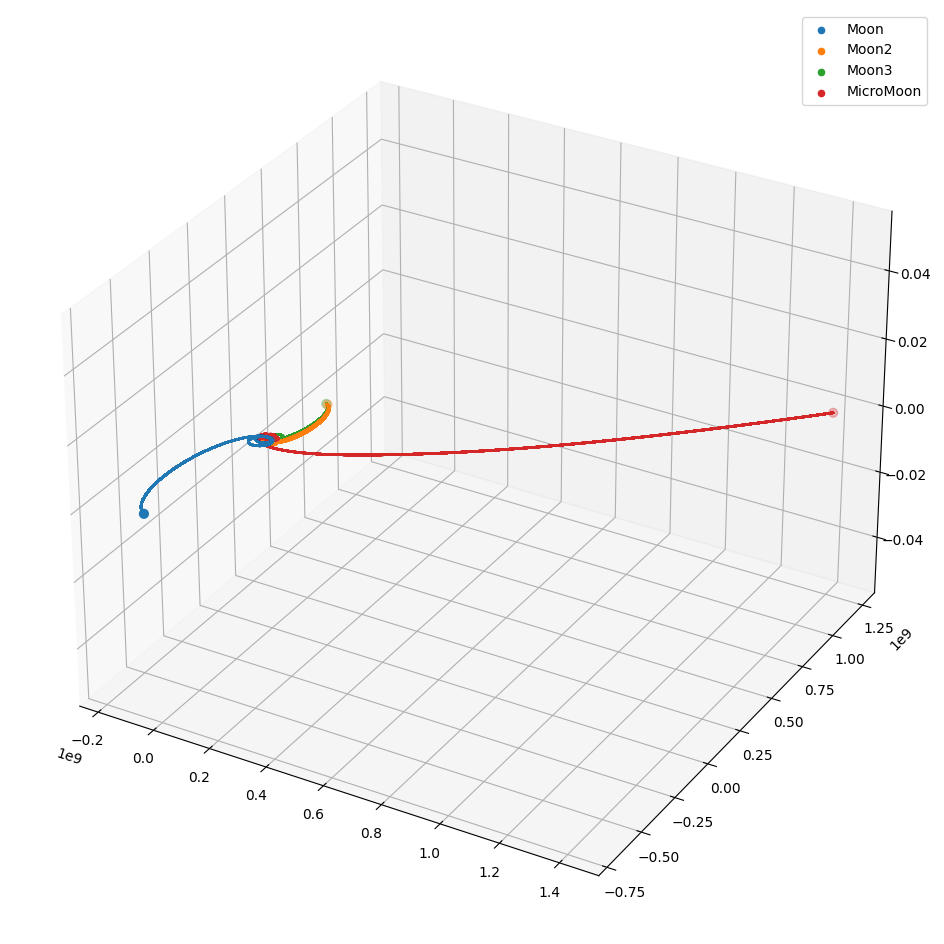

In [20]:
def test3_pokrutilsa_i_uletel():
    
    Moon = SpaceObject("Moon",
                mass = 1e23,
                position = createVector(1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, 1.73, 0) * Size.km / Time.second / 3)

    Moon2 = SpaceObject("Moon2",
                mass = 1e23,
                position = createVector(-1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, -1.73, 0) * Size.km / Time.second / 3)

    Moon3 = SpaceObject("Moon3",
                mass = 1e23,
                position = createVector(0, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(2, 0, 0) * Size.km / Time.second / 3)
    MicroMoon = \
            SpaceObject("MicroMoon",
                mass = 1e20,
                position = createVector(0.5, -2, 0) * Size.km * 6.5e2,
                velocity = createVector(0.1, 1, 0) * Size.km / Time.second / 10)
    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2, Moon3, MicroMoon], systemDE, logger, 4
        )
    simulation.run(100 * Time.day, 2 * Time.minute)
    paint(simulation)
test3_pokrutilsa_i_uletel()

[INFO]: Simulation step 1 / 21600
[MEASUREMENT]: Impulse: [6.66666667e+25 1.34217728e+08 0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000e+00  0.00000e+00 -2.16359e+33]
[MEASUREMENT]: Energy: -2.238572764258598e+28
[INFO]: Simulation step 4321 / 21600
[MEASUREMENT]: Impulse: [ 6.66666667e+25 -6.87194767e+10  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.16357495e+33]
[MEASUREMENT]: Energy: -2.2412043844389038e+28
[INFO]: Simulation step 8641 / 21600
[MEASUREMENT]: Impulse: [ 6.66666667e+25 -1.09521666e+11  0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.16357205e+33]
[MEASUREMENT]: Energy: -2.2414225047705346e+28
[INFO]: Simulation step 12961 / 21600
[MEASUREMENT]: Impulse: [6.66666667e+25 3.86547057e+10 0.00000000e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -2.16356367e+33]
[MEASUREMENT]: Energy: -2.2424019253327074e+28
[INFO]: Simulation step 17281 / 21600
[MEASUREMENT]: Impulse: 

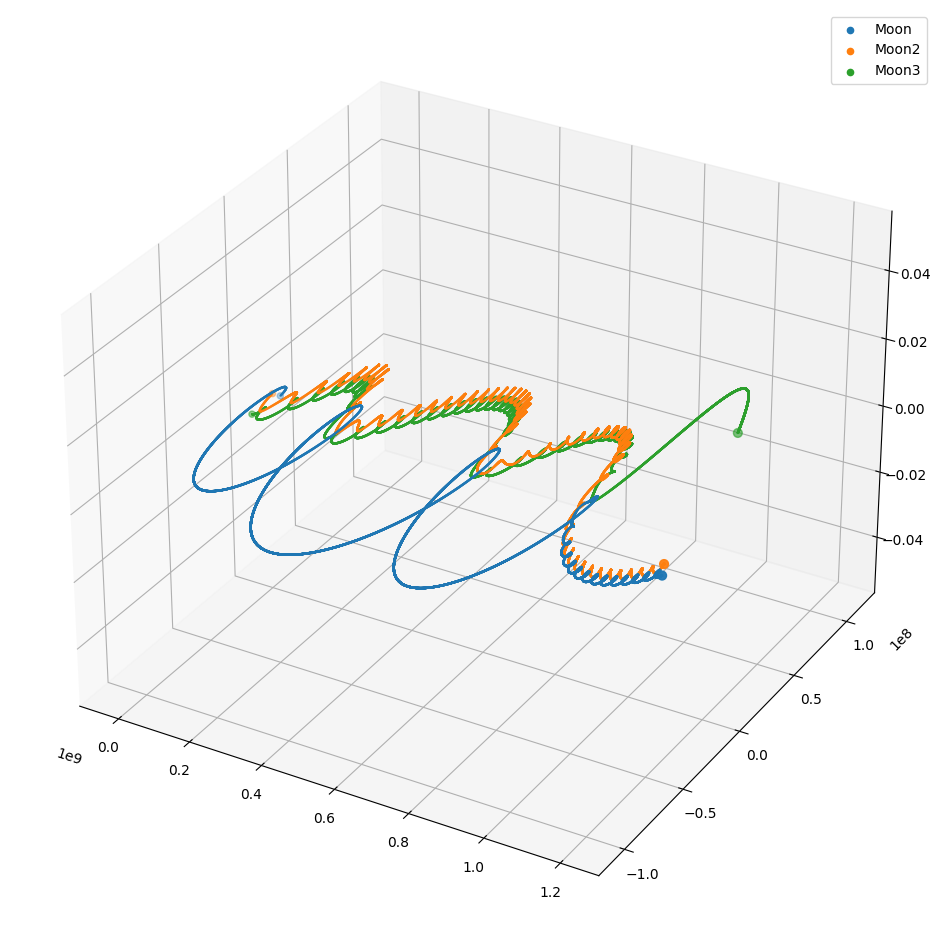

In [58]:
def test3():
    
    Moon = SpaceObject("Moon",
                mass = 1e23,
                position = createVector(1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, 1.73, 0) * Size.km / Time.second / 3)

    Moon2 = SpaceObject("Moon2",
                mass = 1e23,
                position = createVector(-1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(1, -1.73, 0) * Size.km / Time.second / 3)

    Moon3 = SpaceObject("Moon3",
                mass = 1e23,
                position = createVector(0, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(2, 0, 0) * Size.km / Time.second / 3)

    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2, Moon3], systemDE, logger, 5
        )
    simulation.run(60 * Time.day, 4 * Time.minute)
    paint(simulation)
test3()

[INFO]: Simulation step 1 / 259200
[MEASUREMENT]: Impulse: [-1.00e+26 -1.73e+26  0.00e+00]
[MEASUREMENT]: Impulse moment: [ 0.000000e+00  0.000000e+00 -4.097795e+33]
[MEASUREMENT]: Energy: -1.7683249011118894e+29
[INFO]: Simulation step 64801 / 259200
[MEASUREMENT]: Impulse: [-1.00e+26 -1.73e+26  0.00e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -4.09714403e+33]
[MEASUREMENT]: Energy: -1.8633937897371388e+29
[INFO]: Simulation step 129601 / 259200
[MEASUREMENT]: Impulse: [-1.00e+26 -1.73e+26  0.00e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -4.09697091e+33]
[MEASUREMENT]: Energy: -1.868402133718845e+29
[INFO]: Simulation step 194401 / 259200
[MEASUREMENT]: Impulse: [-1.00e+26 -1.73e+26  0.00e+00]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -4.09679739e+33]
[MEASUREMENT]: Energy: -1.8734483787596175e+29
[INFO]: Final configuration:
[MEASUREMENT]: Impulse: [-1.00e+26 -1.73e+26  0.00e+00]
[MEASUREMENT]: Impulse moment: [

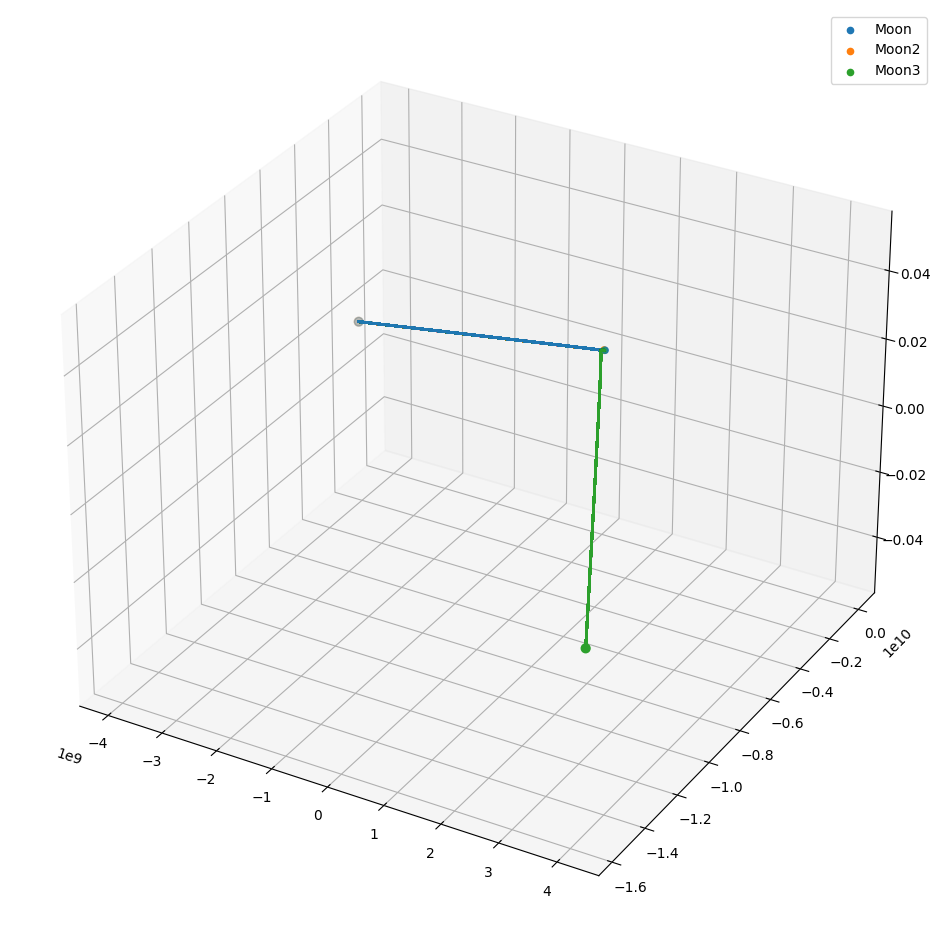

In [11]:
def test3_planet_flies_away_and_two_are_together():
    
    Moon = SpaceObject("Moon",
                mass = 1e23,
                position = createVector(1.73, 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, 1.73, 0) * Size.km / Time.second / 3)

    Moon2 = SpaceObject("Moon2",
                mass = 4e23,
                position = createVector(-1., 1, 0) * Size.km * 6.5e3,
                velocity = createVector(-1, -1.73, 0) * Size.km / Time.second / 3)

    Moon3 = SpaceObject("Moon3",
                mass = 1e23,
                position = createVector(0, -2, 0) * Size.km * 6.5e3,
                velocity = createVector(2, 0, 0) * Size.km / Time.second / 3)

    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2, Moon3], systemDE, logger, 4
        )
    simulation.run(180 * Time.day, 1 * Time.minute)
    paint(simulation)
test3_planet_flies_away_and_two_are_together()

[INFO]: Simulation step 1 / 5400
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [0.00000000e+00 0.00000000e+00 5.76718034e+34]
[MEASUREMENT]: Energy: 7.6276383482107476e+28
[INFO]: Simulation step 136 / 5400
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [0.00000000e+00 0.00000000e+00 5.76718034e+34]
[MEASUREMENT]: Energy: 7.627638348210749e+28
[INFO]: Simulation step 271 / 5400
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [0.00000000e+00 0.00000000e+00 5.76718034e+34]
[MEASUREMENT]: Energy: 7.627638348210758e+28
[INFO]: Simulation step 406 / 5400
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [0.00000000e+00 0.00000000e+00 5.76718034e+34]
[MEASUREMENT]: Energy: 7.62763834821076e+28
[INFO]: Simulation step 541 / 5400
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [0.00000000e+00 0.00000000e+00 5.76718034e+34]
[MEASUREMENT]: Energy: 7.627638348210755e+28
[INFO]: Simulation step 676 / 5400
[M

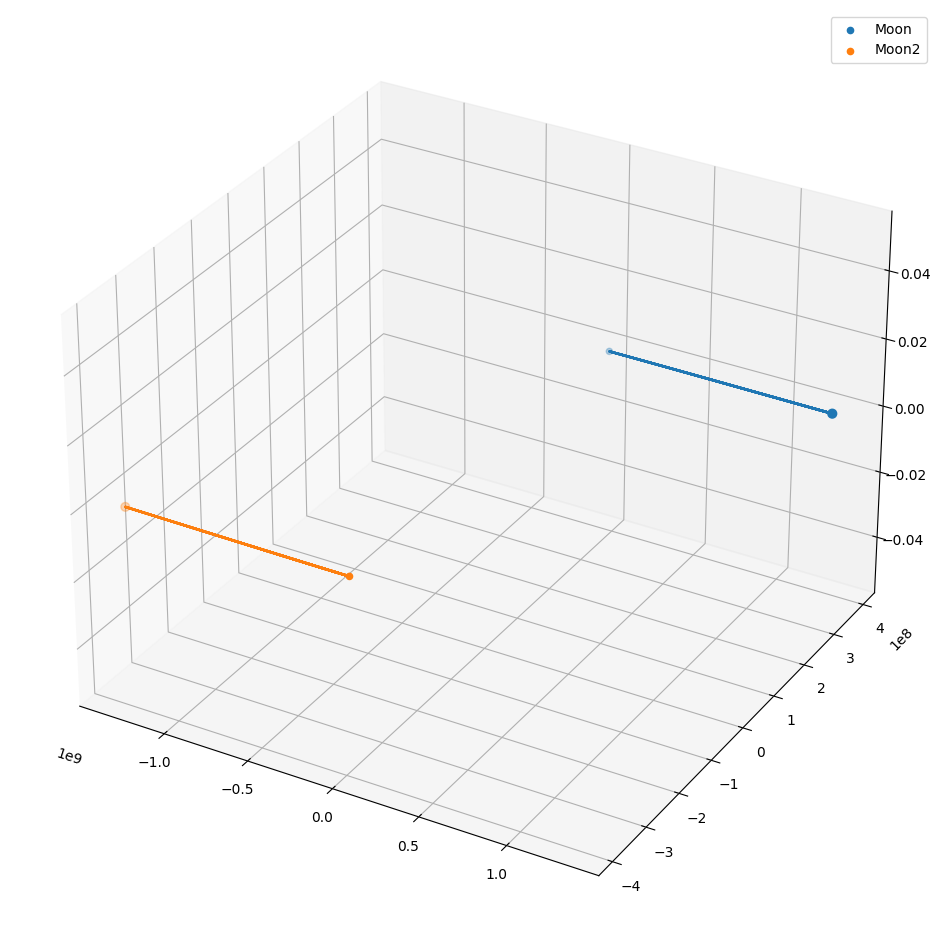

In [10]:
def test_no_interaction():
    
    Moon = SpaceObject("Moon",
            mass = 7.3477e22,
            position = createVector(0, 3.84e5, 0) * Size.km,
            velocity = createVector(1.022, 0, 0) * Size.km / Time.second)

    Moon2 = SpaceObject("Moon2",
            mass = 7.3477e22,
            position = -createVector(0, 3.84e5, 0) * Size.km,
            velocity = -createVector(1.022, 0, 0) * Size.km / Time.second)

    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2], systemDE, logger, 40
        )
    simulation.run(15 * Time.day, 4 * Time.minute)
    paint(simulation)
test_no_interaction()

[INFO]: Simulation step 1 / 21600
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -1.41146378e+32]
[MEASUREMENT]: Energy: -4.41488616148372e+27
[INFO]: Simulation step 541 / 21600
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -1.41140364e+32]
[MEASUREMENT]: Energy: -4.4656990464967955e+27
[INFO]: Simulation step 1081 / 21600
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -1.41140364e+32]
[MEASUREMENT]: Energy: -4.4656990464975014e+27
[INFO]: Simulation step 1621 / 21600
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -1.41140364e+32]
[MEASUREMENT]: Energy: -4.4656990464975146e+27
[INFO]: Simulation step 2161 / 21600
[MEASUREMENT]: Impulse: [0. 0. 0.]
[MEASUREMENT]: Impulse moment: [ 0.00000000e+00  0.00000000e+00 -1.41140364e+32]
[MEASUREMENT]: Energy: -4.465699046497515e+27
[INFO]:

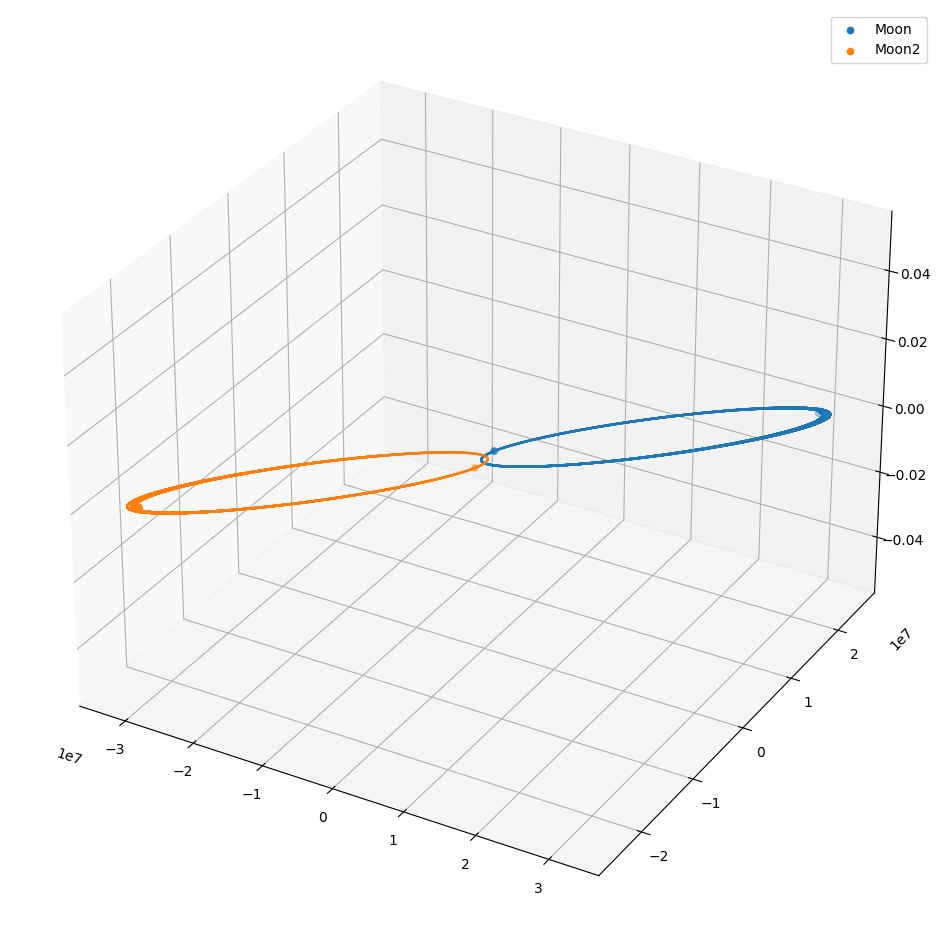

In [58]:
def test_convergence():
    
    Moon = SpaceObject("Moon",
            mass = 7.3477e22,
            position = createVector(0, 1.84e3, 0) * Size.km,
            velocity = -createVector(0.522, 1, 0) * Size.km / Time.second)

    Moon2 = SpaceObject("Moon2",
            mass = 7.3477e22,
            position = -createVector(0, 1.84e3, 0) * Size.km,
            velocity = createVector(0.522, 1, 0) * Size.km / Time.second)

    logger = PrintLogger()
    simulation = Simulation(
        [Moon, Moon2], systemDE, logger, 40
        )
    simulation.run(15 * Time.day, 1 * Time.minute)
    paint(simulation)
test_convergence()

[INFO]: Simulation step 1 / 15120
[MEASUREMENT]: Impulse: [ 7.5047956e+25  3.0868800e+23 -1.1009000e+23]
[MEASUREMENT]: Impulse moment: [9.44158002e+28 2.00044814e+31 2.88193956e+34]
[MEASUREMENT]: Energy: -3.807245074386794e+28
[INFO]: Simulation step 379 / 15120
[MEASUREMENT]: Impulse: [ 7.5047956e+25  3.0868800e+23 -1.1009000e+23]
[MEASUREMENT]: Impulse moment: [9.44157966e+28 2.00044814e+31 2.88193956e+34]
[MEASUREMENT]: Energy: -3.8072450748176574e+28
[INFO]: Simulation step 757 / 15120
[MEASUREMENT]: Impulse: [ 7.5047956e+25  3.0868800e+23 -1.1009000e+23]
[MEASUREMENT]: Impulse moment: [9.44157966e+28 2.00044814e+31 2.88193956e+34]
[MEASUREMENT]: Energy: -3.807245074817672e+28
[INFO]: Simulation step 1135 / 15120
[MEASUREMENT]: Impulse: [ 7.5047956e+25  3.0868800e+23 -1.1009000e+23]
[MEASUREMENT]: Impulse moment: [9.44157930e+28 2.00044814e+31 2.88193956e+34]
[MEASUREMENT]: Energy: -3.8072450752498236e+28
[INFO]: Simulation step 1513 / 15120
[MEASUREMENT]: Impulse: [ 7.5047956e+2

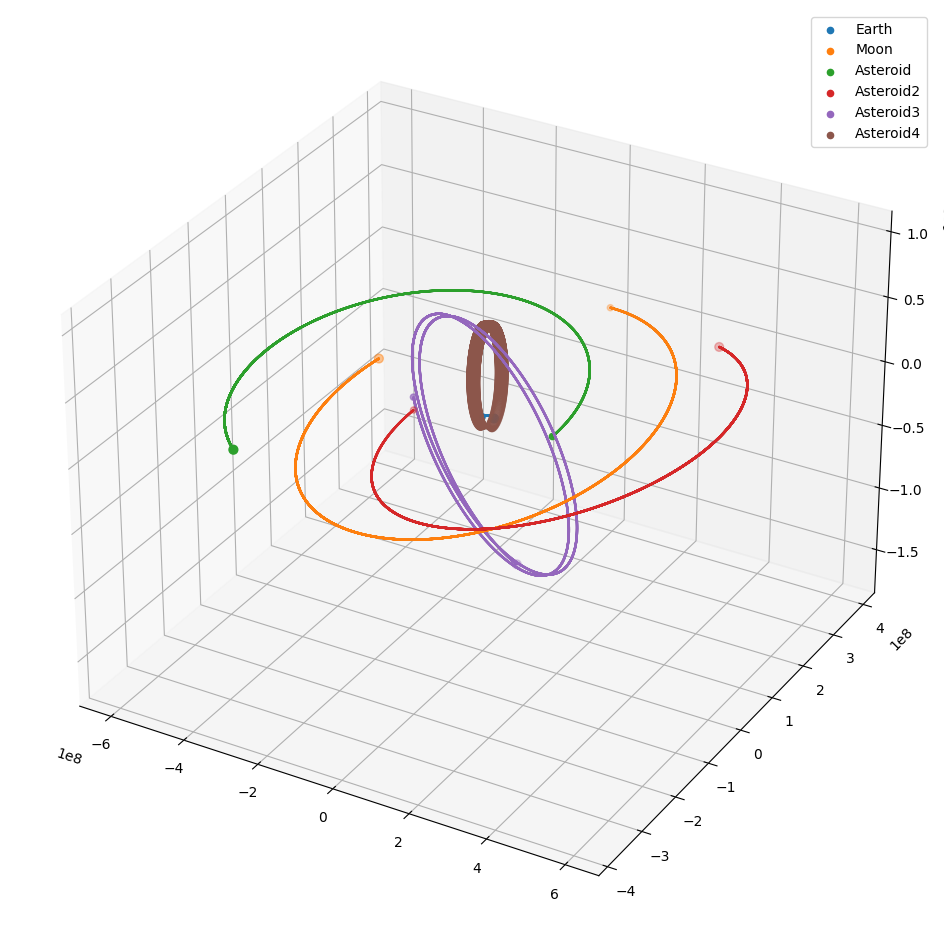

In [31]:
def test6():
    
    Moon = SpaceObject("Moon",
                mass = 7.3477e22,
                position = createVector(0, 3.84e5, 0) * Size.km,
                velocity = createVector(1.022, 0, 0) * Size.km / Time.second)

    Earth = SpaceObject("Earth",
                mass = Constants.massEarth,
                position = createVector(0, 0, 0) * Size.km,
                velocity = createVector(0, 0, 0) * Size.km / Time.second)

    Asteroid1 = SpaceObject("Asteroid",
                mass = 1.09e20,
                position = createVector(1.84e5, 0, 1e2) * Size.km,
                velocity = createVector(0, 1822, 0) * Size.m / Time.second)

    Asteroid2 = SpaceObject("Asteroid2",
                mass = 1.09e10,
                position = createVector(-1.84e5, 0, -1e4) * Size.km,
                velocity = createVector(1, -1822, 0) * Size.m / Time.second)

    Asteroid3 = SpaceObject("Asteroid3",
                mass = 1.09e20,
                position = createVector(-1.84e5, 0, 0) * Size.km,
                velocity = createVector(-0.422, 1, -1) * Size.km / Time.second)

    Asteroid4 = SpaceObject("Asteroid4",
                mass = 1.09e18,
                position = createVector(1.84e4, 0, 6.84e4) * Size.km,
                velocity = createVector(0.422, 1, -1) * Size.km / Time.second)

    logger = PrintLogger()
    simulation = Simulation(
        [Earth, Moon, Asteroid1, Asteroid2, Asteroid3, Asteroid4], systemDE, logger, 40
        )
    simulation.run(21 * Time.day, 2 * Time.minute)

    paint(simulation)

test6()